# SHO Fitting in Pytorch

In [3]:
import sys
sys.path.append('../../')


In [4]:
# import tools

import matplotlib.pyplot as plt
import numpy as np
import h5py
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

from src.m3_learning.optimizers.AdaHessian import AdaHessian
from src.m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
from src.m3_learning.be.processing import convert_amp_phase
from src.m3_learning.util.preprocessing import global_scaler
from src.m3_learning.nn.random import random_seed
from src.m3_learning.nn.benchmarks.inference import computeTime

## Loads Data

In [5]:

# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
raw_data_resampled = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# conversion of raw data (both resampled and full)
amp, phase = convert_amp_phase(raw_data)
amp_resample, phase_resample = convert_amp_phase(raw_data_resampled)

scaled_data = h5_f["Measurement_000"]["Channel_000"]['complex']['scaled_data'][:]
real_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['real_resample'][:]
imag_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][:]

# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)


In [6]:
# TODO extract fit params

# create a list for parameters
fit_results_list = []
for sublist in np.array(
    h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"]
):
    for item in sublist:
        for i in item:
            fit_results_list.append(i)

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# exclude the R2 parameter
params = fit_results_list.reshape(-1, 5)[:, 0:4]

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. This will validate that the function is identical.

Note: This uses the results from the least squares fitting LSQF results. 

spectra number 78536


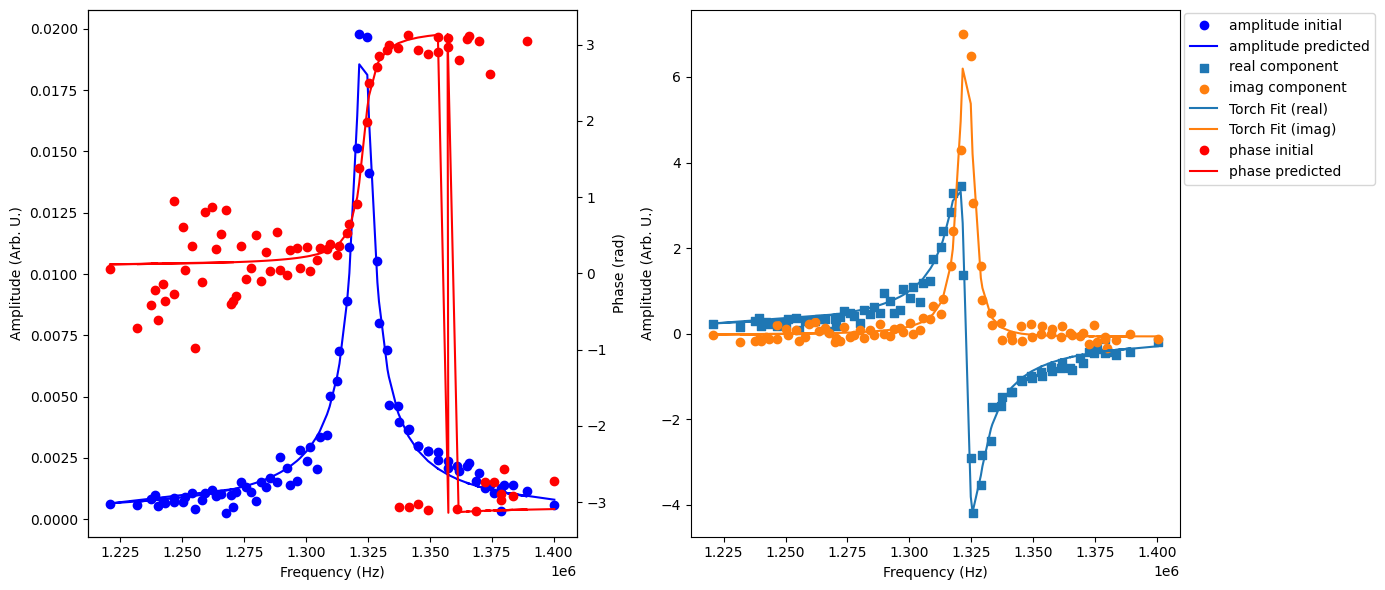

In [7]:
# plot the initial and reconstructed by SHO Fitting Function data
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# selects a random index
i = np.random.randint(0, scaled_data_real.shape[0])

# computes the fit using the torch model
out = SHO_fit_func_torch(torch.tensor(np.atleast_2d(params[i])), wvec_freq)

# converts to amplitude and phase
amp_pred, phase_pred = convert_amp_phase(out)

print(f"spectra number {i}")
axs[0].plot(
    wvec_freq, amp_resample[i, :], "o", label="amplitude initial", color="b"
)
axs[0].plot(
    wvec_freq, amp_pred[0, :], label="amplitude predicted", color="b"
)
axs[0].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = axs[0].twinx()
ax2.plot(wvec_freq, phase_resample[i, :], "o", label="phase initial", color="r")
ax2.plot(wvec_freq, phase_pred[0, :], label="phase predicted", color="r")
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)")

axs[1].scatter(wvec_freq, scaled_data_real[i, :], label="real component", marker="s")
axs[1].scatter(wvec_freq, scaled_data_imag[i, :], label="imag component", marker="o")
axs[1].plot(
    wvec_freq, scaler_real.transform(torch.real(out[0])), label="Torch Fit (real)"
)
axs[1].plot(
    wvec_freq, scaler_imag.transform(torch.imag(out[0])), label="Torch Fit (imag)"
)
axs[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.15, 0.97), loc="upper right", borderaxespad=0.0)

## Pytorch Model

### Model Architecture

![](Assets\Figures\model_architecture_sho.png)

### Builds the Model

In [8]:
class SHO_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        # fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear
        self.hidden_embedding = nn.Sequential(
            nn.Linear(26, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 4),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # output shape - samples, (real, imag), frequency
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(x, (n, 2, 128))  # batch size, (real, imag), timesteps
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.
        embedding = self.hidden_embedding(encoded)  # output is 4 parameters

        # corrects the scaling of the parameters
        unscaled_param = (
            embedding * torch.tensor(params_scaler.var_[0:4] ** 0.5).cuda()
            + torch.tensor(params_scaler.mean_[0:4]).cuda()
        )

        # passes to the pytorch fitting function
        fits = SHO_fit_func_torch(unscaled_param, wvec_freq, device="cuda")

        # extract and return real and imaginary
        real = torch.real(fits)
        real_scaled = (real - torch.tensor(scaler_real.mean).cuda()) / torch.tensor(
            scaler_real.std
        ).cuda()
        imag = torch.imag(fits)
        imag_scaled = (imag - torch.tensor(scaler_imag.mean).cuda()) / torch.tensor(
            scaler_imag.std
        ).cuda()
        out = torch.stack((real_scaled, imag_scaled), 2)
        return out

### Test/Train Split

In [9]:
data_train, data_test, params_train, params_test = train_test_split(
    scaled_data, scaled_params, test_size=0.7, random_state=42
)

params_test_unscaled = params_scaler.inverse_transform(params_test)

### Training

In [ ]:
model = SHO_Model().cuda().double()

print(model)

SHO_Model(
  (hidden_x1): Sequential(
    (0): Conv1d(2, 8, kernel_size=(7,), stride=(1,))
    (1): SELU()
    (2): Conv1d(8, 6, kernel_size=(7,), stride=(1,))
    (3): SELU()
    (4): Conv1d(6, 4, kernel_size=(5,), stride=(1,))
    (5): SELU()
  )
  (hidden_xfc): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): SELU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SELU()
  )
  (hidden_x2): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv1d(2, 4, kernel_size=(5,), stride=(1,))
    (2): SELU()
    (3): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (4): SELU()
    (5): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (6): SELU()
    (7): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (8): SELU()
    (9): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (10): SELU()
    (11): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (12): SELU()
    (13): AvgPool1d(kernel_size=(2,), 

In [ ]:
# Note that the seed will behave differently on different hardware targets (GPUs)
random_seed(seed=42)

torch.cuda.empty_cache()

loss_func = torch.nn.MSELoss()
batch_size = 200

# uncomment the code below if you want to try Adahessian
optimizer = torch.optim.Adam(model.parameters())
# optimizer = AdaHessian(model.parameters(), lr=0.1) #0.1

train_dataloader = DataLoader(data_train, batch_size=batch_size)

epochs = 5

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in train_dataloader:

        pred = model(train_batch.double().cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.double().cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num
    # torch.save(model, './Trained Models/SHO Fitting/model_AdaHessian.pt')
    # torch.save(model.state_dict(), './Trained Models/SHO Fitting/model_AdaHessian.pth')

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
epoch : 1/5, recon loss = 0.06889800
--- 32.59125566482544 seconds ---
epoch : 2/5, recon loss = 0.04336922
--- 34.14324688911438 seconds ---
epoch : 3/5, recon loss = 0.04289337
--- 32.978540658950806 seconds ---
epoch : 4/5, recon loss = 0.04270399
--- 31.7340030670166 seconds ---
epoch : 5/5, recon loss = 0.04255622
--- 31.995166540145874 seconds ---


In [ ]:
### Calculate Inference Time

torch.cuda.empty_cache()

bs = int(.5e6)
train_dataloader_valid = DataLoader(data_train, batch_size=bs)

# Computes the inference time
computeTime(model, next(iter(train_dataloader_valid)).double(), batch_size=bs)

Avg execution time (ms): 0.002597


### Validation Reconstruction

In [ ]:
# prediction of reconstructions
batch_size = 100000
train_dataloader = DataLoader(data_test, batch_size=batch_size)

num_elements = len(train_dataloader.dataset)
num_batches = len(train_dataloader)
predictions = torch.zeros_like(torch.tensor(data_test))

for i, train_batch in enumerate(train_dataloader):
    start = i * batch_size
    end = start + batch_size

    if i == num_batches - 1:
        end = num_elements

    pred_batch = model(train_batch.double().cuda())
    predictions[start:end] = pred_batch.cpu().detach()

    del pred_batch
    del train_batch
    torch.cuda.empty_cache()

In [ ]:
data_test_unscaled = data_test.copy()
predictions_unscaled = predictions.numpy().copy()

data_test_unscaled[:, :, 0] = scaler_real.inverse_transform(data_test_unscaled[:, :, 0])
data_test_unscaled[:, :, 1] = scaler_imag.inverse_transform(data_test_unscaled[:, :, 1])
data_test_unscaled = data_test_unscaled[:, :, 0] + 1j * data_test_unscaled[:, :, 1]

predictions_unscaled[:, :, 0] = scaler_real.inverse_transform(
    predictions_unscaled[:, :, 0]
)
predictions_unscaled[:, :, 1] = scaler_imag.inverse_transform(
    predictions_unscaled[:, :, 1]
)
predictions_unscaled = (
    predictions_unscaled[:, :, 0] + 1j * predictions_unscaled[:, :, 1]
)

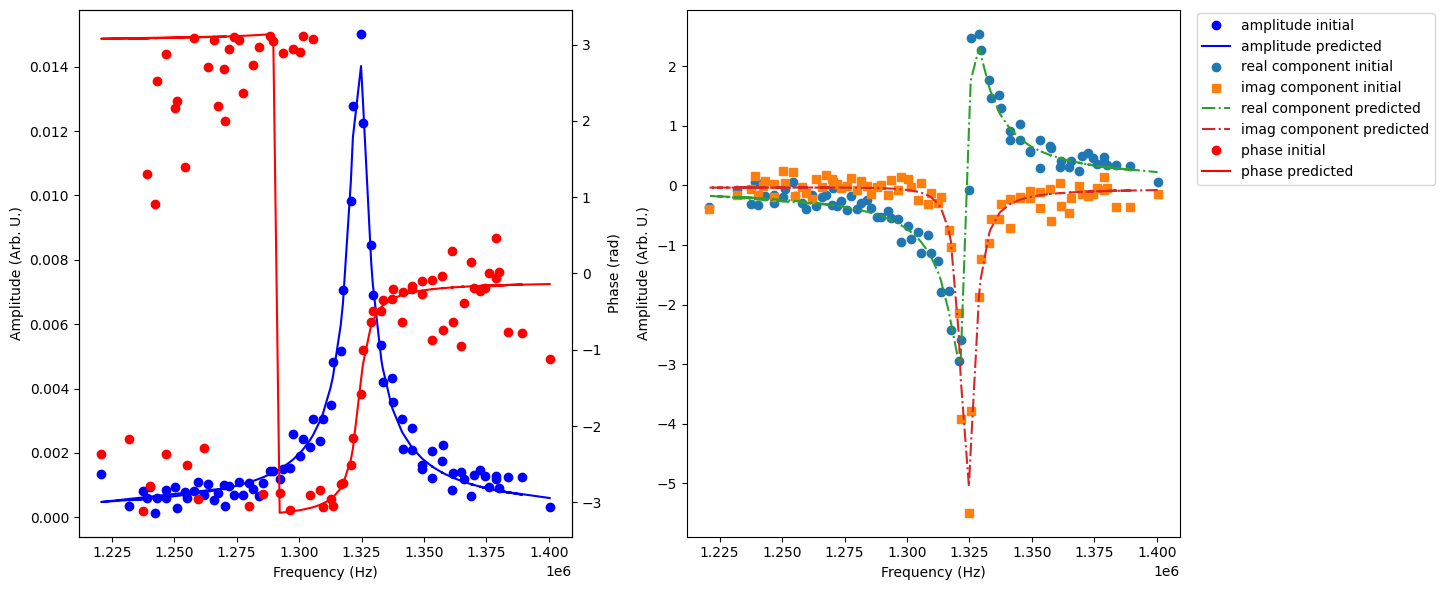

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

i = np.random.randint(0, predictions.shape[0])
magnitude_graph_test, phase_graph_test = convert_amp_phase(
    np.atleast_2d(data_test_unscaled[i, :])
)
magnitude_graph_pred, phase_graph_pred = convert_amp_phase(
    np.atleast_2d(predictions_unscaled[i, :])
)

axs[0].plot(
    wvec_freq, magnitude_graph_test[0, :], "o", label="amplitude initial", color="b"
)
axs[0].plot(
    wvec_freq, magnitude_graph_pred[0, :], label="amplitude predicted", color="b"
)
axs[0].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = axs[0].twinx()
ax2.plot(wvec_freq, phase_graph_test[0, :], "o", label="phase initial", color="r")
ax2.plot(wvec_freq, phase_graph_pred[0, :], label="phase predicted", color="r")
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)")

axs[1].plot(wvec_freq, data_test[i][:, 0], "o", label="real component initial")
axs[1].plot(wvec_freq, data_test[i][:, 1], "s", label="imag component initial")
axs[1].plot(
    wvec_freq,
    predictions[i].cpu().detach().numpy()[:, 0],
    "-.",
    label="real component predicted",
)
axs[1].plot(
    wvec_freq,
    predictions[i].cpu().detach().numpy()[:, 1],
    "-.",
    label="imag component predicted",
)
axs[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.2, 0.97), loc="upper right", borderaxespad=0.0)

### Visualize Best/Worst Results

In [3]:
mse_real = mean_squared_error(
    data_test[:, :, 0], predictions[:, :, 0].cpu().detach().numpy()
)
mse_imag = mean_squared_error(
    data_test[:, :, 1], predictions[:, :, 1].cpu().detach().numpy()
)
print("MSE for real component: " + str(mse_real))
print("MSE for imaginary component: " + str(mse_imag))

error = (mse_real + mse_imag) / 2.0
print("Average MSE: " + str(error))

errors = np.sum(
    np.mean(np.square(data_test - predictions.cpu().detach().numpy()), 1), 1
)
errors = np.asarray(errors)
print(errors.shape)

NameError: name 'data_test' is not defined

NameError: name 'test_pred_params' is not defined